In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def plot_metrics(distribution: str):
    file_path = f"../out/metrics_{distribution}.csv"

    # Load the CSV file with the exact column names from the file
    df = pd.read_csv(file_path)

    # Calculate TTFT (Time to First Token) and ITL (Inter Token Latency)
    df["TTFT"] = df["first_scheduled_time"] - df["arrival_time"]
    df["ITL"] = df["last_token_time"] - df["first_scheduled_time"]

    # Plot TTFT and ITL
    plt.figure(figsize=(10, 6))
    plt.hist(df["TTFT"], bins=30, alpha=0.7, label="TTFT", color='blue')
    plt.hist(df["ITL"], bins=30, alpha=0.7, label="ITL", color='orange')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency")
    plt.title("Distribution of TTFT and ITL")
    plt.legend()
    plt.show()

    # Group by 'lora_name' and calculate mean TTFT and ITL
    grouped = df.groupby("lora_name").agg({"TTFT": "mean", "ITL": "mean"}).reset_index()

    # Plot grouped TTFT and ITL for each 'lora_name'
    plt.figure(figsize=(12, 6))
    plt.bar(grouped["lora_name"], grouped["TTFT"], alpha=0.7, label="TTFT", color='blue')
    plt.bar(grouped["lora_name"], grouped["ITL"], alpha=0.7, label="ITL", color='orange', bottom=grouped["TTFT"])
    plt.xlabel("LoRA")
    plt.ylabel("Time (seconds)")
    plt.title("Average TTFT and ITL Grouped by LoRA")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

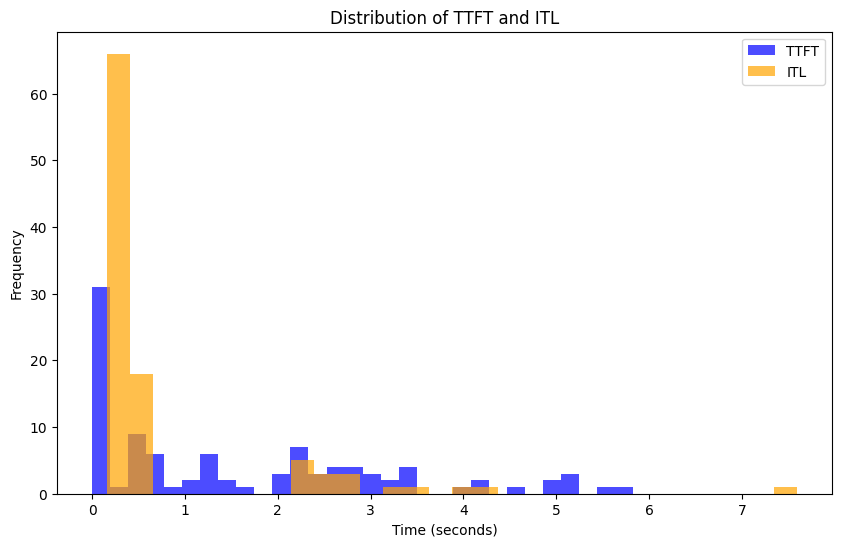

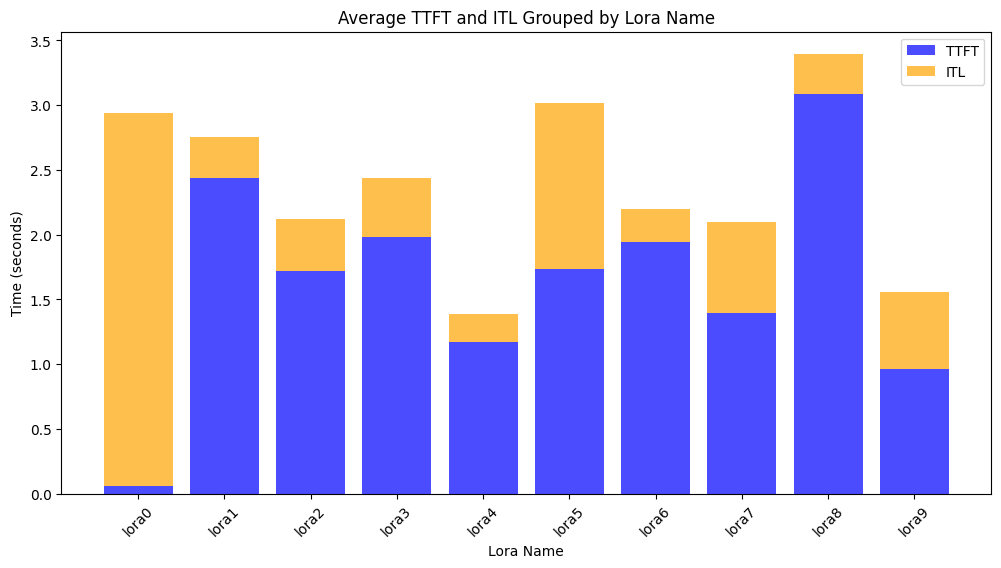

In [16]:
plot_metrics("uniform")

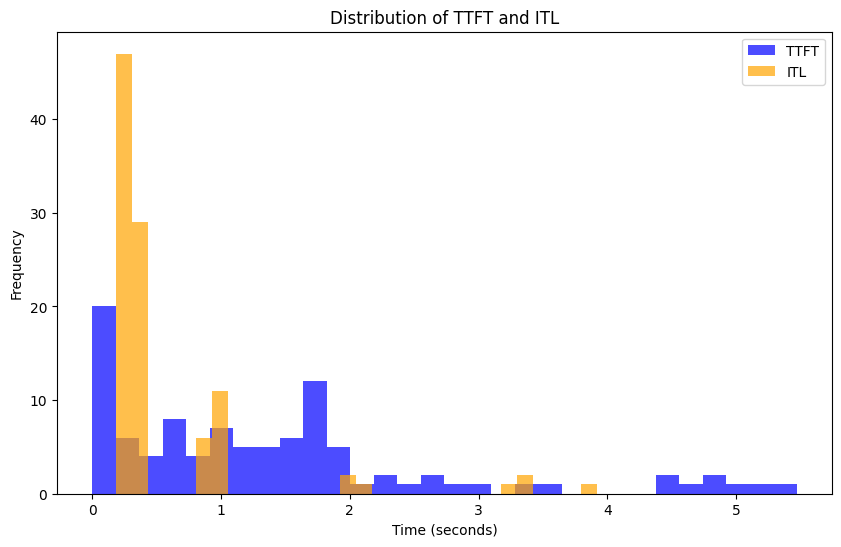

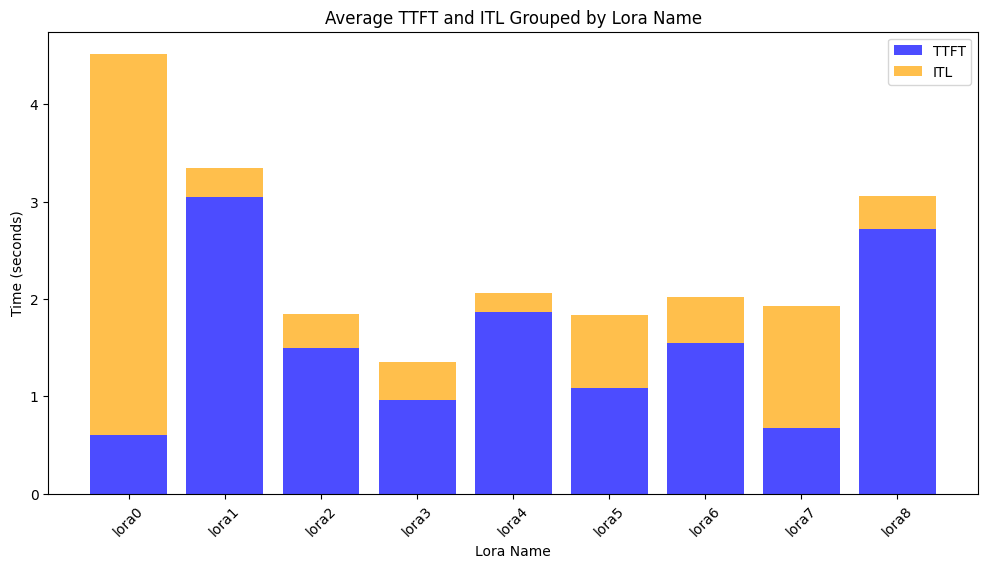

In [17]:
plot_metrics("normal")